# EDA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import PIL.ImageDraw
import seaborn as sns
import tqdm.notebook as tqdm

import dataclasses
import pathlib
import pprint

sns.set_theme(style="whitegrid")

In [2]:
root = pathlib.Path("../../data/ds_yolo").resolve()

## Изображения

Датасет состоит из train и val выборок. Каждая выборка состоит из 1002 изображений. Все изображения имеют одинаковый размер 1280х720. Метаданных у изображений нет.

In [3]:
for split in ["train", "val"]:
    dir_ = root / "images" / split
    cnt = 0
    for path in dir_.iterdir():
        cnt += 1
        img = PIL.Image.open(dir_ / path)
        assert img.width == 1280 and img.height == 720
        assert len(img.getexif()) == 0    # no metadata
    print(f"{cnt} images in {split}")

1002 images in train
1002 images in val


Каждое изображение -- это кадр из видеоклипа. Названия файлов с изображениями имеют вид `IDКлипа_НомерКадра.jpg`. Выборка train состоит из кадров из двух разных клипов, а выборка val целиком состоит из кадров одного клипа, отличного от первых двух. Посчитаем число кадров, относящихся к каждому клипу:

In [4]:
counts = {}
for split in ["train", "val"]:
    dir_ = root / "images" / split
    counts[split] = {}
    for path in dir_.iterdir():
        clip, frame = path.stem.rsplit("_", maxsplit=1)
        if clip not in counts[split]:
            counts[split][clip] = 0
        counts[split][clip] += 1
pprint.pprint(counts, width=40)

{'train': {'v_-6Os86HzwCs_c001_img1': 825,
           'v_-6Os86HzwCs_c003_img1': 177},
 'val': {'v_00HRwkvvjtQ_c001_img1': 1002}}


Оба клипа в train выборке взяты из одного матча кубка Азии по женскому баскетболу, а клип в val выборке взят из матча по мужскому студенческому баскетболу в США.

Пример кадра из каждой выборки:

In [5]:
sample_path_t = "images/train/v_-6Os86HzwCs_c001_img1_000001.jpg"
sample_path_v = "images/val/v_00HRwkvvjtQ_c001_img1_000122.jpg"

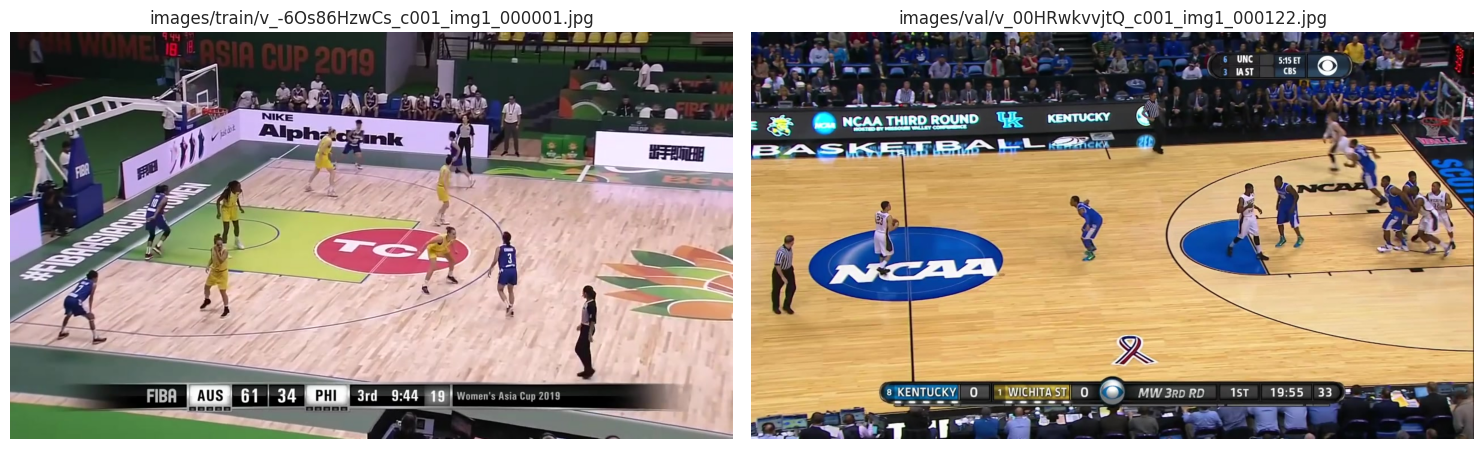

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

axs[0].imshow(PIL.Image.open(root / sample_path_t))
axs[0].set_title(sample_path_t)
axs[0].axis("off")

axs[1].imshow(PIL.Image.open(root / sample_path_v))
axs[1].set_title(sample_path_v)
axs[1].axis("off")

plt.tight_layout()

Посчитаем среднее значение и стандартное отклонение выборок по каждому цветовому каналу (аккуратно, чтобы не сохранять в память весь датасет одновременно).

In [7]:
for split in ["train", "val"]:
    dir_ = root / "images" / split
    total_pixels = 1002 * 1280 * 720

    color_totals = np.asarray([0.0, 0.0, 0.0])
    for path in tqdm.tqdm(dir_.iterdir(), total=1002):
        arr = np.asarray(PIL.Image.open(dir_ / path))  # [720, 1280, 3]
        color_totals += arr.reshape(-1, 3).sum(axis=0)
    color_means = color_totals / total_pixels

    color_sqdiff_totals = np.asarray([0.0, 0.0, 0.0])
    for path in tqdm.tqdm(dir_.iterdir(), total=1002):
        arr = np.asarray(PIL.Image.open(dir_ / path))  # [720, 1280, 3]
        color_sqdiff_totals += ((arr.reshape(-1, 3) - color_means) ** 2).sum(axis=0)
    color_stds = np.sqrt(color_sqdiff_totals / total_pixels)

    print(f"{split} color channel means: {color_means}")
    print(f"{split} color channel stds:  {color_stds}")

  0%|          | 0/1002 [00:00<?, ?it/s]

  0%|          | 0/1002 [00:00<?, ?it/s]

train color channel means: [137.27219933 120.68123541 118.1094893 ]
train color channel stds:  [83.80221349 72.25826771 71.8358903 ]


  0%|          | 0/1002 [00:00<?, ?it/s]

  0%|          | 0/1002 [00:00<?, ?it/s]

val color channel means: [129.19895727 113.47570446  94.49167428]
val color channel stds:  [92.52993241 73.77954119 54.1053887 ]


## Bounding boxes

Для каждого изображения есть некоторое количество bounding box'ов, которые соответствуют игрокам, присутствующим в этом изображении.

In [8]:
@dataclasses.dataclass
class Bbox:
    label: int
    cx: float
    cy: float
    width: float
    height: float

In [9]:
bboxes = {}
for split in ["train", "val"]:
    dir_ = root / "labels" / split
    bboxes[split] = {}
    for path in dir_.iterdir():
        bboxes[split][path.stem] = []
        for line in path.read_text().split("\n"):
            elems = map(float, line.split())
            bboxes[split][path.stem].append(Bbox(*elems))

    counts = [len(bbs) for bbs in bboxes[split].values()]
    print(f"{split} avg bboxes per image: {sum(counts) / len(counts):.2f}")

train avg bboxes per image: 9.82
val avg bboxes per image: 9.66


Пример:

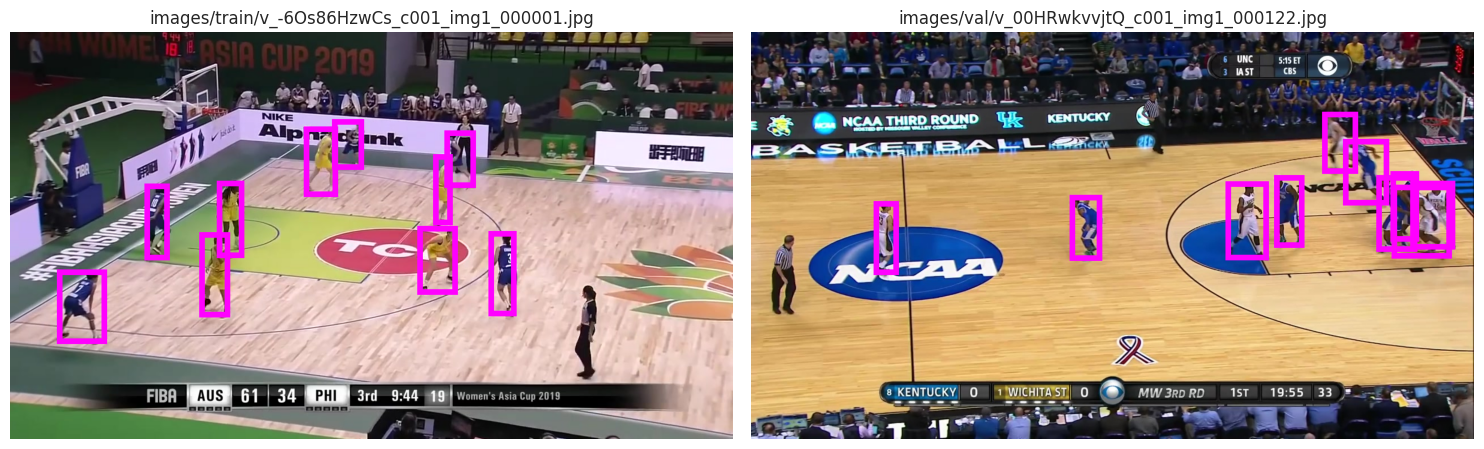

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

for path, ax in zip([sample_path_t, sample_path_v], axs):
    full_path = root / path
    img = PIL.Image.open(full_path)
    draw = PIL.ImageDraw.Draw(img)
    for bbox in bboxes[full_path.parent.stem][full_path.stem]:
        draw.rectangle(
            [
                (bbox.cx - bbox.width / 2) * 1280,
                (bbox.cy - bbox.height / 2) * 720,
                (bbox.cx + bbox.width / 2) * 1280,
                (bbox.cy + bbox.height / 2) * 720
            ],
            outline="magenta",
            width=10
        )
    ax.imshow(img)
    ax.set_title(path)
    ax.axis("off")

plt.tight_layout()

Все bbox'ы имеют одну и ту же метку класса 0. В этой задаче класс всего один.

In [11]:
for split in bboxes:
    for frame in bboxes[split]:
        for box in bboxes[split][frame]:
            assert box.label == 0

Визуализируем распределения числа bbox'ов в изображениях и размеров bbox'ов.

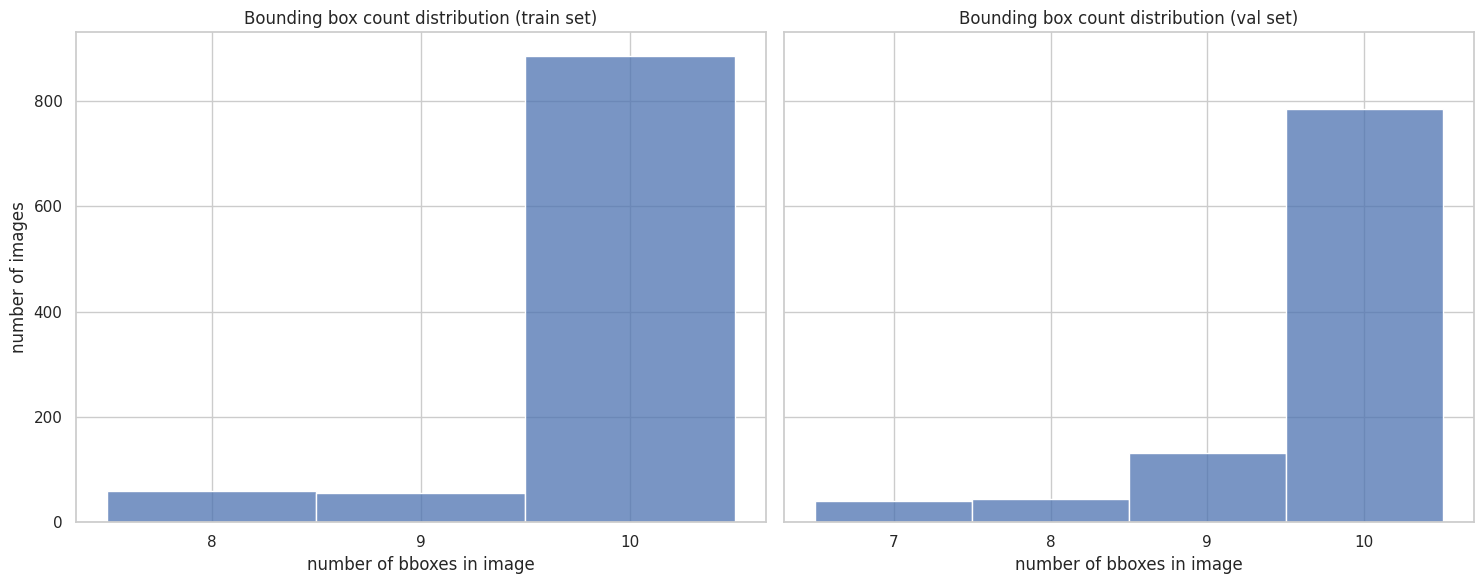

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)

counts_t = [len(bbs) for bbs in bboxes["train"].values()]
counts_v = [len(bbs) for bbs in bboxes["val"].values()]

sns.histplot(counts_t, discrete=True, ax=axs[0])
axs[0].set_title("Bounding box count distribution (train set)")
axs[0].set_xticks(range(min(counts_t), max(counts_t) + 1))
sns.histplot(counts_v, discrete=True, ax=axs[1])
axs[1].set_title("Bounding box count distribution (val set)")
axs[1].set_xticks(range(min(counts_v), max(counts_v) + 1))

for ax in axs:
    ax.set_xlabel("number of bboxes in image")
    ax.set_ylabel("number of images")

plt.tight_layout();

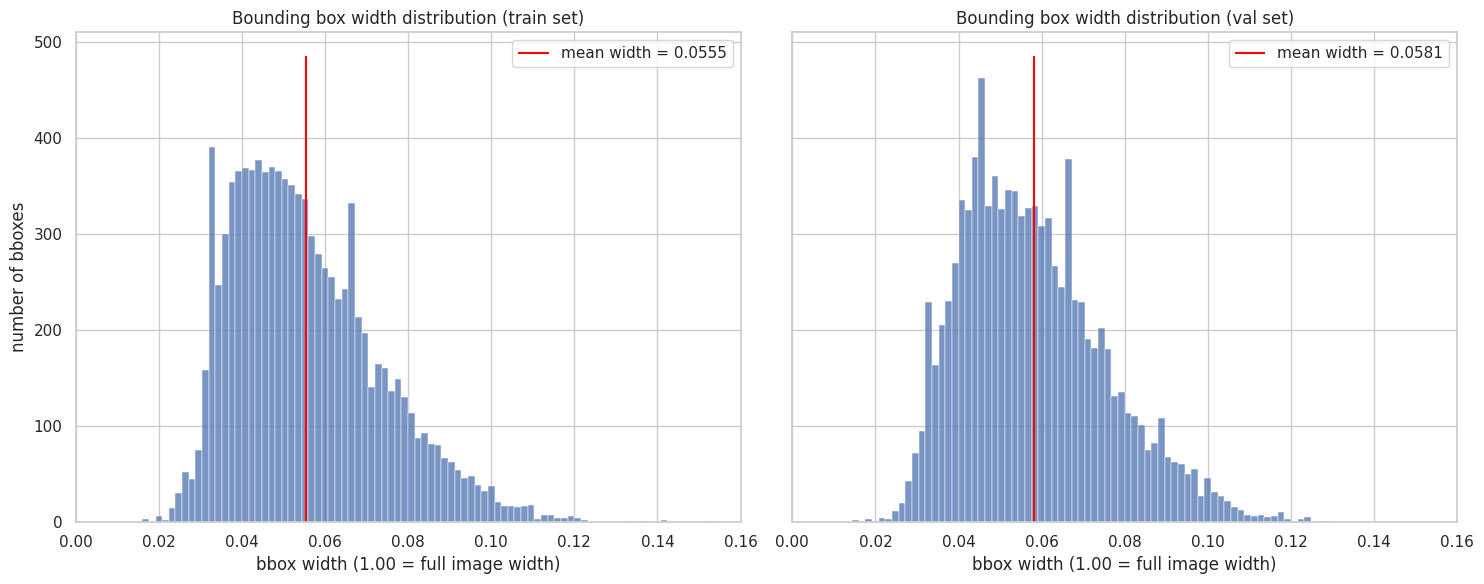

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)

widths_t = []
for bbs in bboxes["train"].values():
    widths_t += [bb.width for bb in bbs]
widths_v = []
for bbs in bboxes["val"].values():
    widths_v += [bb.width for bb in bbs]

sns.histplot(widths_t, bins=100, binrange=(0, 0.16), ax=axs[0])
axs[0].set_title("Bounding box width distribution (train set)")
sns.histplot(widths_v, bins=100, binrange=(0, 0.16), ax=axs[1])
axs[1].set_title("Bounding box width distribution (val set)")

ymin, ymax = axs[0].get_ylim()
mean_t = np.mean(widths_t)
axs[0].vlines(x=mean_t, ymin=ymin, ymax=ymax, colors="red", label=f"mean width = {mean_t:.4f}")
mean_v = np.mean(widths_v)
axs[1].vlines(x=mean_v, ymin=ymin, ymax=ymax, colors="red", label=f"mean width = {mean_v:.4f}")

for ax in axs:
    ax.set_xlabel("bbox width (1.00 = full image width)")
    ax.set_ylabel("number of bboxes")
    ax.set_xlim(0, 0.16)
    ax.legend()

plt.tight_layout()

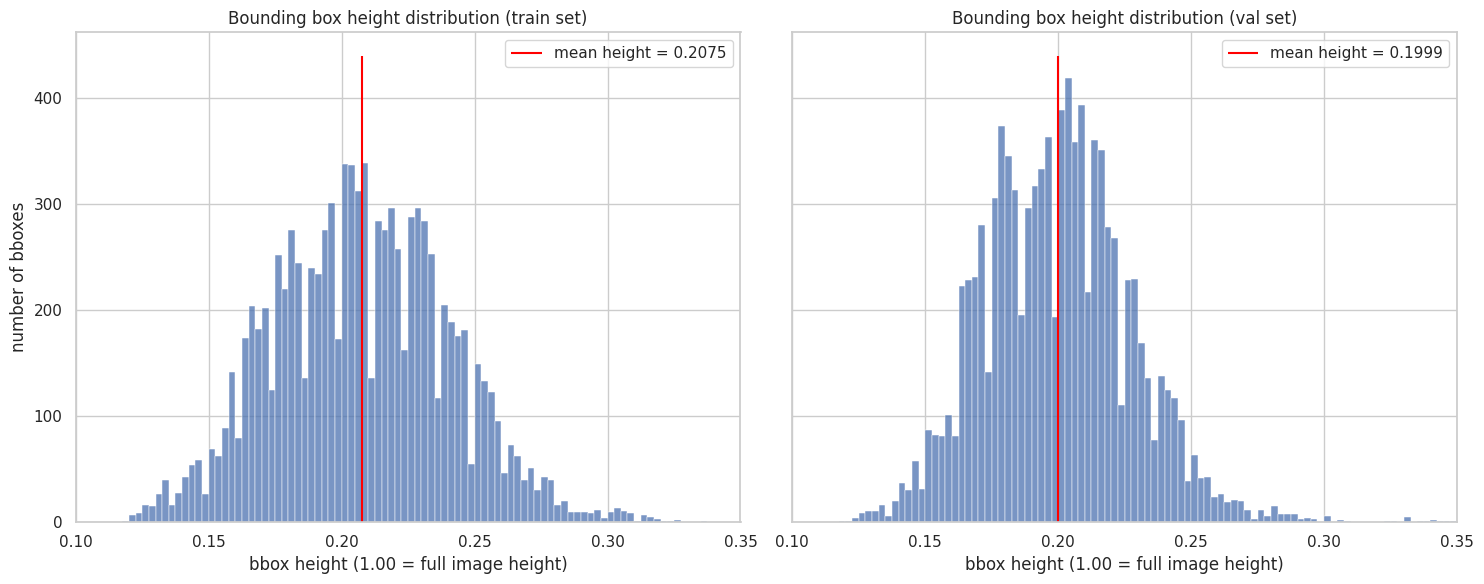

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)

heights_t = []
for bbs in bboxes["train"].values():
    heights_t += [bb.height for bb in bbs]
heights_v = []
for bbs in bboxes["val"].values():
    heights_v += [bb.height for bb in bbs]

sns.histplot(heights_t, bins=100, binrange=(0.1, 0.35), ax=axs[0])
axs[0].set_title("Bounding box height distribution (train set)")
sns.histplot(heights_v, bins=100, binrange=(0.1, 0.35), ax=axs[1])
axs[1].set_title("Bounding box height distribution (val set)")

ymin, ymax = axs[0].get_ylim()
mean_t = np.mean(heights_t)
axs[0].vlines(x=mean_t, ymin=ymin, ymax=ymax, colors="red", label=f"mean height = {mean_t:.4f}")
mean_v = np.mean(heights_v)
axs[1].vlines(x=mean_v, ymin=ymin, ymax=ymax, colors="red", label=f"mean height = {mean_v:.4f}")

for ax in axs:
    ax.set_xlabel("bbox height (1.00 = full image height)")
    ax.set_ylabel("number of bboxes")
    ax.set_xlim(0.1, 0.35)
    ax.legend()

plt.tight_layout();

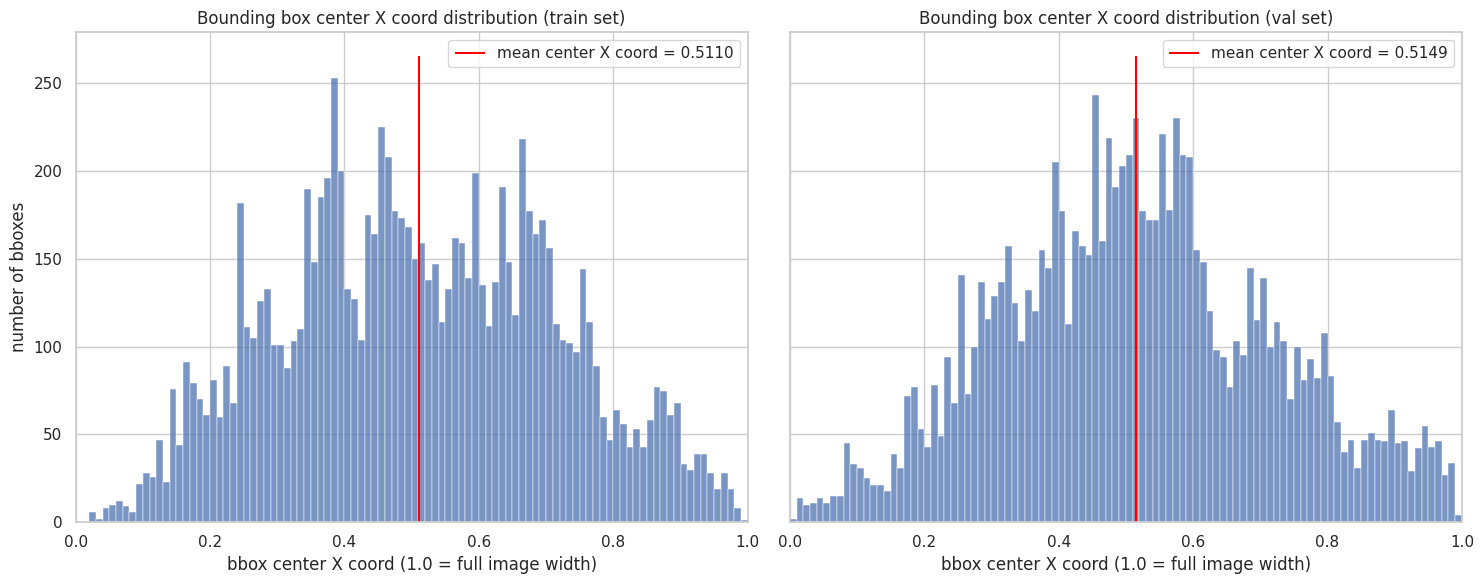

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)

cxs_t = []
for bbs in bboxes["train"].values():
    cxs_t += [bb.cx for bb in bbs]
cxs_v = []
for bbs in bboxes["val"].values():
    cxs_v += [bb.cx for bb in bbs]

sns.histplot(cxs_t, bins=100, binrange=(0, 1), ax=axs[0])
axs[0].set_title("Bounding box center X coord distribution (train set)")
sns.histplot(cxs_v, bins=100, binrange=(0, 1), ax=axs[1])
axs[1].set_title("Bounding box center X coord distribution (val set)")

ymin, ymax = axs[0].get_ylim()
mean_t = np.mean(cxs_t)
axs[0].vlines(x=mean_t, ymin=ymin, ymax=ymax, colors="red", label=f"mean center X coord = {mean_t:.4f}")
mean_v = np.mean(cxs_v)
axs[1].vlines(x=mean_v, ymin=ymin, ymax=ymax, colors="red", label=f"mean center X coord = {mean_v:.4f}")

for ax in axs:
    ax.set_xlabel("bbox center X coord (1.0 = full image width)")
    ax.set_ylabel("number of bboxes")
    ax.set_xlim(0, 1)
    ax.legend()

plt.tight_layout();

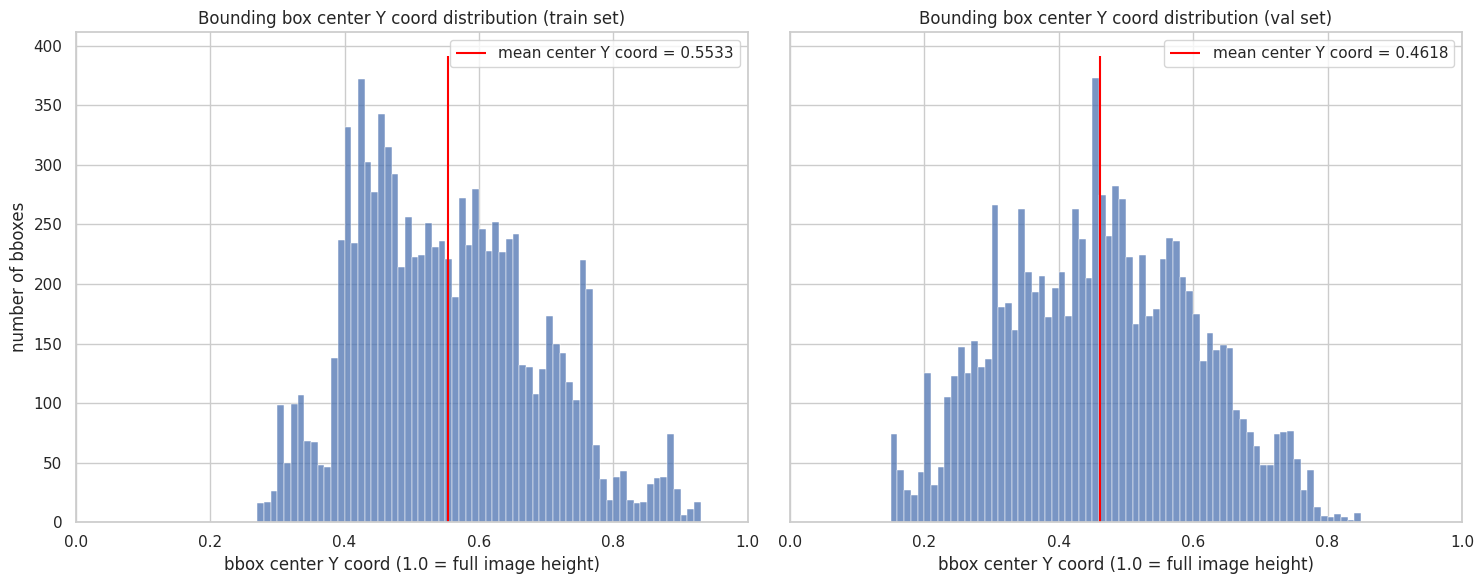

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)

cys_t = []
for bbs in bboxes["train"].values():
    cys_t += [bb.cy for bb in bbs]
cys_v = []
for bbs in bboxes["val"].values():
    cys_v += [bb.cy for bb in bbs]

sns.histplot(cys_t, bins=100, binrange=(0, 1), ax=axs[0])
axs[0].set_title("Bounding box center Y coord distribution (train set)")
sns.histplot(cys_v, bins=100, binrange=(0, 1), ax=axs[1])
axs[1].set_title("Bounding box center Y coord distribution (val set)")

ymin, ymax = axs[0].get_ylim()
mean_t = np.mean(cys_t)
axs[0].vlines(x=mean_t, ymin=ymin, ymax=ymax, colors="red", label=f"mean center Y coord = {mean_t:.4f}")
mean_v = np.mean(cys_v)
axs[1].vlines(x=mean_v, ymin=ymin, ymax=ymax, colors="red", label=f"mean center Y coord = {mean_v:.4f}")

for ax in axs:
    ax.set_xlabel("bbox center Y coord (1.0 = full image height)")
    ax.set_ylabel("number of bboxes")
    ax.set_xlim(0, 1)
    ax.legend()

plt.tight_layout();

Выводы в файле [`eda.md`](./eda.md).